# 02. Neuralnet Q Learning example

Neuralnet Q Learning을 실습해봅니다.
- 신경망의 parameter(weight)를 업데이트 함에 따라 state에 대한 Q value가 변화합니다.
- Q Learning의 TD error를 loss function으로 하여 학습합니다.

## Colab 용 package 설치 코드

In [ ]:
!pip install gym

### Package import

In [1]:
import tensorflow as tf
import numpy as np
import random
import gym

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(777)
tf.set_random_seed(777)

print("tensorflow version: ", tf.__version__)
print("gym version: ", gym.__version__)

tensorflow version:  1.8.0
gym version:  0.11.0


## Frozen Lake

**[state]**

        SFFF
        FHFH
        FFFH
        HFFG

    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located
    
**[action]**

    LEFT = 0
    DOWN = 1
    RIGHT = 2
    UP = 3

### Frozen Lake (not Slippery)

In [2]:
def register_frozen_lake_not_slippery(name):
    from gym.envs.registration import register
    register(
        id=name,
        entry_point='gym.envs.toy_text:FrozenLakeEnv',
        kwargs={'map_name' : '4x4', 'is_slippery': False},
        max_episode_steps=100,
        reward_threshold=0.78, # optimum = .8196
    )

register_frozen_lake_not_slippery('FrozenLakeNotSlippery-v0')

In [3]:
# Load Environment
env = gym.make('FrozenLakeNotSlippery-v0')
state_size = env.observation_space.n
action_size = env.action_space.n
print("State_size : ", state_size)
print("Action_size: ",action_size)

State_size :  16
Action_size:  4


## Q-Learning using Neural Network  
**Update 식**  
  
$J(w) = \mathbb{E}_{\pi}[(target - \hat q(S,A,w))^2]$  
  
$ \begin{align} \Delta w & = - \frac{1}{2} \alpha \nabla_w J(w)
\\ & = \alpha (R_{t+1} + \gamma max(\hat q(S_{t+1},a ,w)) - \hat q(S_{t},A_{t},w))\nabla_w \hat q(S_{t},A_{t},w) \end{align}$

### 학습 순서
1. 초기 state 받음 (env.reset())
2. action 선택 (e - greedy policy)
3. 선택한 action으로 다음 state로 이동 (env.step())
4. 다음 state와 reward를 이용해 update식 작성
5. 신경망 업데이트
6. 반복

## Tensorflow 코드 흐름
1. 각 연산자에 대한 그래프를 구성한다.
2. 실제 데이터를 그래프에 할당하면서 전체 그래프를 실행한다.

### Build graph

In [4]:
layers = tf.contrib.layers

# placeholder 선언
inputs = tf.placeholder(shape=[1], dtype=tf.int32, name="state")
input_action = tf.placeholder(shape=[1], dtype=tf.int32, name="action")
target = tf.placeholder(shape=[1], dtype=tf.float32, name="targetQ")

# 신경망 구성 함수
def build_network(inputs):   
    with tf.variable_scope('q_net'):
        input_onehot = tf.one_hot(inputs, state_size, dtype=tf.float32)
        fc1 = layers.fully_connected(inputs=input_onehot,
                                     num_outputs=4,
                                     activation_fn=None)
    return fc1

# 신경망 구성
q_value = build_network(inputs)

# 현재 action에 대한 Q_value 구하는 연산
curr_action = tf.one_hot(input_action, action_size)
curr_q_value = tf.reduce_sum(tf.multiply(q_value, curr_action))

# Loss 함수 구성
loss_op = tf.square(target - curr_q_value)
opt = tf.train.GradientDescentOptimizer(learning_rate=0.1)
train_op = opt.minimize(loss_op)

### Executing a graph in a tf.Session

In [5]:
# Session 열기
sess = tf.Session()

# 변수 초기화
sess.run(tf.global_variables_initializer())

# 변수(파라미터) 확인
for var in tf.trainable_variables('q_net'):
    print(var)
    print(sess.run(var))

<tf.Variable 'q_net/fully_connected/weights:0' shape=(16, 4) dtype=float32_ref>
[[-6.0733646e-02 -3.5827678e-01  4.8103058e-01 -3.7636170e-01]
 [-3.2480127e-01 -5.3931355e-02  2.8314555e-01 -3.4480178e-01]
 [ 4.8399687e-02  2.0780110e-01  1.8425167e-01  3.6608332e-01]
 [-2.3245859e-01 -5.3794265e-01 -9.6173316e-02 -3.3918953e-01]
 [ 2.8697640e-01  2.5819421e-02  1.7191756e-01 -1.5600085e-02]
 [-4.2137003e-01 -4.4634092e-01  3.1198454e-01 -1.4007688e-02]
 [-1.0566205e-01 -3.1236708e-02 -4.6822315e-01 -1.9728965e-01]
 [ 3.0298996e-01 -3.6282149e-01 -3.9720133e-01  2.0609957e-01]
 [-4.4529909e-01  1.6861230e-01  3.8679183e-02  5.2380562e-04]
 [ 4.8956716e-01 -8.1262350e-02 -3.0587435e-02  1.5888274e-01]
 [-2.5100735e-01 -4.3752733e-01  2.5761116e-01  5.2036798e-01]
 [ 1.1219704e-01 -3.5665569e-01  1.9697464e-01  2.5190800e-01]
 [-3.2989496e-01 -3.1735718e-02  1.5875924e-01  5.2931142e-01]
 [ 4.9331117e-01 -4.3476018e-01  3.9276057e-01 -1.5144280e-01]
 [-3.6021417e-01 -3.6626130e-01 -2.123

### Action select using Q value

In [6]:
state = env.reset()
state = np.reshape(state, [1])
print("current state:", state)

curr_q = sess.run(q_value, feed_dict={inputs: state})
print("Q value of current state:", curr_q)

action = sess.run(q_value, feed_dict={inputs: state})
action = np.argmax(action, axis=1)
action = action[0]
print("choose action: ", action)

current state: [0]
Q value of current state: [[-0.06073365 -0.35827678  0.48103058 -0.3763617 ]]
choose action:  2


### 선택한 Action으로 다음 State, Reward 받기

In [7]:
next_state, reward, done, _ = env.step(action)
next_state = np.reshape(next_state, [1])
print("next_state", next_state)

gamma = 0.9
if done:
    next_q_value = np.array([reward])
else:
    next_q_value = reward + gamma * np.max(sess.run(q_value, feed_dict={inputs: next_state}), axis=1)
print("next_q_value", next_q_value)

next_state [1]
next_q_value [0.254831]


### Update Neural Net

In [8]:
action = np.reshape(action, [1])

# train_op를 sess.run 하여 학습 실행.
loss, _ = sess.run([loss_op, train_op], feed_dict={inputs: state, target: next_q_value, input_action: action})
print("loss", loss)

for var in tf.trainable_variables('q_net'):
    print(var)
    print(sess.run(var))

loss [0.05116626]
<tf.Variable 'q_net/fully_connected/weights:0' shape=(16, 4) dtype=float32_ref>
[[-6.0733646e-02 -3.5827678e-01  4.3579066e-01 -3.7636170e-01]
 [-3.2480127e-01 -5.3931355e-02  2.8314555e-01 -3.4480178e-01]
 [ 4.8399687e-02  2.0780110e-01  1.8425167e-01  3.6608332e-01]
 [-2.3245859e-01 -5.3794265e-01 -9.6173316e-02 -3.3918953e-01]
 [ 2.8697640e-01  2.5819421e-02  1.7191756e-01 -1.5600085e-02]
 [-4.2137003e-01 -4.4634092e-01  3.1198454e-01 -1.4007688e-02]
 [-1.0566205e-01 -3.1236708e-02 -4.6822315e-01 -1.9728965e-01]
 [ 3.0298996e-01 -3.6282149e-01 -3.9720133e-01  2.0609957e-01]
 [-4.4529909e-01  1.6861230e-01  3.8679183e-02  5.2380562e-04]
 [ 4.8956716e-01 -8.1262350e-02 -3.0587435e-02  1.5888274e-01]
 [-2.5100735e-01 -4.3752733e-01  2.5761116e-01  5.2036798e-01]
 [ 1.1219704e-01 -3.5665569e-01  1.9697464e-01  2.5190800e-01]
 [-3.2989496e-01 -3.1735718e-02  1.5875924e-01  5.2931142e-01]
 [ 4.9331117e-01 -4.3476018e-01  3.9276057e-01 -1.5144280e-01]
 [-3.6021417e-01 -3.

### 학습 시작

In [9]:
rlist = []
slist = []
epsilon_list = []

EPISODE = 2000
gamma = 0.99

update_count = 0
loss_list = []

# Episode 수만큼 반복
for step in range(EPISODE):
    epsilon = 1. / ((step/50)+10)
    epsilon_list.append(epsilon)
    
    state = env.reset()
    state = np.reshape(state, [1])
    print("[Episode {}]".format(step))
    total_reward = 0
    limit = 0
    done = False
    
    while not done and limit < 99:        
        # 현재 state의 Q value불러오기
        
        # e-greedy policy로 action 선택
        if epsilon > np.random.random():
            # random
            action = env.action_space.sample()
        else:
            # greedy
            curr_q = sess.run(q_value, feed_dict={inputs: state})
            action = np.argmax(curr_q)   
            
        # 선택한 action으로 env.step 하기
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1])
                          
        if reward == 1.0:
            print("GOAL")
        
        # 업데이트를 위한 (미래)보상값 반환
        # episode가 끝났다면
        if done:
            next_q_value = np.array([reward])
        # 끝나지 않았다면
        else:
            next_q_value = reward + gamma * np.max(sess.run(q_value, feed_dict={inputs: next_state}), axis=1)
        
        # Q update
        action = np.reshape(action, [1])
        loss, _ = sess.run([loss_op, train_op], feed_dict={inputs: state, target: next_q_value, input_action: action})
        loss_list.append(loss)
        update_count += 1
        
        slist.append(state.item())
        state = next_state
        total_reward += reward
        limit += 1
        
    print(slist)
    slist = []
    print("total reward: ", total_reward)
    rlist.append(total_reward)
    
print("Success prob: " + str(sum(rlist) / EPISODE) + "%")

[Episode 0]
[0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6]
total reward:  0.0
[Episode 1]
[0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 6]
total reward:  0.0
[Episode 2]
[0, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 6]
total reward:  0.0
[Episode 3]
[0, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1]
total reward:  0.0
[Episode 4]
[0, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 3, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 6]
total reward:  0.0
[Episode 5]
[0, 1, 2, 2, 2, 2, 2, 3, 2, 1]
total reward:  0.0
[Episode 6]
[0, 1, 2, 3, 2, 1, 2, 3, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1]
total reward:  0.0
[Episode 7]
[0, 1, 2, 1, 2, 1, 0, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 6]
total reward:  0.0
[Episode 8]
[0, 1, 2, 1, 2, 1]
total reward:  0.0
[Episode 9]
[0, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 6]
total reward:  0.0
[E

[0, 1, 2, 6, 10, 9, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 8, 4, 8, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
total reward:  0.0
[Episode 61]
[0, 1, 2, 6, 10, 9, 8, 4, 8, 4, 0, 1, 2, 3, 2, 6, 10, 9, 8, 4, 8, 4, 8, 4, 8, 4, 8, 4, 8, 4, 8, 4, 8, 4, 8, 4, 8, 4, 8, 4, 8, 4, 8, 9, 8, 4, 8, 4, 8, 4, 8, 4, 8, 4, 0, 1, 2, 6, 10, 9, 8, 4, 0, 1, 2, 6, 10, 9, 8, 4, 0, 1, 2, 6, 10, 9, 8, 4, 0, 1, 2, 6, 10, 9, 8, 4, 0, 1, 2, 6, 10, 9, 8, 4]
total reward:  0.0
[Episode 62]
[0, 1]
total reward:  0.0
[Episode 63]
[0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 1, 2, 3, 2, 6, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3]
total reward:  0.0
[Episode 64]
[0, 1, 2, 6, 2, 6, 2, 6, 2, 6, 2, 6, 2, 6, 10, 9, 8, 4, 0, 1, 2, 6, 10, 9, 8, 4, 0, 1, 2, 6, 10, 9, 8, 4, 0, 1, 1, 2, 6, 10, 9, 8, 4, 0, 

[0, 1, 2, 6, 10, 9, 8, 4, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 6, 2, 6, 10, 9, 8, 4, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 6, 10, 9, 8, 4, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
total reward:  0.0
[Episode 103]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
total reward:  0.0
[Episode 104]
[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 3, 2, 6, 2, 1, 2, 1, 2, 1, 2, 6, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
total reward:  0.0
[Episode 105]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1]
total reward:  0.0
[Episode 106]
[0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1]
total reward:  0.0
[Episode 107]
[0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0

GOAL
[0, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 6, 10, 14]
total reward:  1.0
[Episode 154]
GOAL
[0, 1, 2, 3, 3, 2, 6, 10, 14]
total reward:  1.0
[Episode 155]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 156]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 157]
GOAL
[0, 4, 8, 9, 13, 14]
total reward:  1.0
[Episode 158]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 159]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 160]
GOAL
[0, 4, 8, 9, 10, 14]
total reward:  1.0
[Episode 161]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 162]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 163]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 164]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 165]
GOAL
[0, 1, 2, 6, 10, 14, 13, 14]
total reward:  1.0
[Episode 166]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Ep

GOAL
[0, 1, 2, 6, 10, 14, 13, 14]
total reward:  1.0
[Episode 286]
[0, 1, 2, 6, 10]
total reward:  0.0
[Episode 287]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 288]
[0, 1, 2, 2, 6]
total reward:  0.0
[Episode 289]
GOAL
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 2, 6, 10, 14, 13, 14]
total reward:  1.0
[Episode 290]
GOAL
[0, 1, 2, 2, 2, 6, 10, 14]
total reward:  1.0
[Episode 291]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 292]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 293]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 294]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 295]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 296]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 297]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 298]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 299]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 300]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 301]
GOAL
[0, 1, 2,

GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 424]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 425]
[0, 0, 1, 2, 6]
total reward:  0.0
[Episode 426]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 427]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 428]
GOAL
[0, 0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 429]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 430]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 431]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 432]
[0, 1]
total reward:  0.0
[Episode 433]
GOAL
[0, 1, 2, 2, 6, 10, 6, 10, 14]
total reward:  1.0
[Episode 434]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 435]
GOAL
[0, 0, 1, 2, 2, 2, 6, 10, 14]
total reward:  1.0
[Episode 436]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 437]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 438]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 439]
GOAL
[0, 1, 2, 3, 2, 6, 10, 14]
total reward:  1.0
[Episode 440

GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 568]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 569]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 570]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 571]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 572]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 573]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 574]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 575]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 576]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 577]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 578]
GOAL
[0, 1, 2, 6, 10, 14, 14]
total reward:  1.0
[Episode 579]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 580]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 581]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 582]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 583]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episod

GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 709]
GOAL
[0, 1, 2, 3, 2, 6, 10, 14]
total reward:  1.0
[Episode 710]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 711]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 712]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 713]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 714]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 715]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 716]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 717]
[0, 1, 2, 6, 10]
total reward:  0.0
[Episode 718]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 719]
GOAL
[0, 1, 2, 3, 2, 6, 10, 14]
total reward:  1.0
[Episode 720]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 721]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 722]
[0, 1, 2, 6]
total reward:  0.0
[Episode 723]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 724]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 725]
GOAL
[0

GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 853]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 854]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 855]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 856]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 857]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 858]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 859]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 860]
GOAL
[0, 1, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 861]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 862]
[0, 1, 2, 6]
total reward:  0.0
[Episode 863]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 864]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 865]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 866]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 867]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 868]
GOAL
[0, 0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 869]
GOAL

GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 994]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 995]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 996]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 997]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 998]
GOAL
[0, 1, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 999]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1000]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1001]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1002]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1003]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1004]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1005]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1006]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1007]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1008]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1009]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.

GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1136]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1137]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1138]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1139]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1140]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1141]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1142]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1143]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1144]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1145]
[0, 1, 2, 6]
total reward:  0.0
[Episode 1146]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1147]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1148]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1149]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1150]
[0, 1, 2, 6]
total reward:  0.0
[Episode 1151]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1152]
GOAL
[

GOAL
[0, 1, 2, 6, 10, 14, 13, 14]
total reward:  1.0
[Episode 1277]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1278]
GOAL
[0, 1, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1279]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1280]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1281]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1282]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1283]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1284]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1285]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1286]
GOAL
[0, 1, 0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1287]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1288]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1289]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1290]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1291]
[0, 1, 2, 6]
total reward:  0.0
[Episode 1292]
GOAL
[0, 1, 2, 6, 10, 14]
total rewa

GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1425]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1426]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1427]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1428]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1429]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1430]
[0, 1, 2, 6]
total reward:  0.0
[Episode 1431]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1432]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1433]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1434]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1435]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1436]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1437]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1438]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1439]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1440]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode

[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1572]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1573]
[0, 1]
total reward:  0.0
[Episode 1574]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1575]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1576]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1577]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1578]
GOAL
[0, 1, 2, 6, 10, 14, 13, 14]
total reward:  1.0
[Episode 1579]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1580]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1581]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1582]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1583]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1584]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1585]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1586]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1587]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 15

[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1718]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1719]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1720]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1721]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1722]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1723]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1724]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1725]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1726]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1727]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1728]
GOAL
[0, 4, 0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1729]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1730]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1731]
[0, 1]
total reward:  0.0
[Episode 1732]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1733]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1734

GOAL
[0, 0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1865]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1866]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1867]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1868]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1869]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1870]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1871]
[0, 1, 2, 6, 10]
total reward:  0.0
[Episode 1872]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1873]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1874]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1875]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1876]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1877]
GOAL
[0, 1, 2, 6, 10, 14, 10, 14]
total reward:  1.0
[Episode 1878]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1879]
GOAL
[0, 1, 2, 6, 10, 14]
total reward:  1.0
[Episode 1880]
GOAL
[0, 1, 2, 6, 10, 14]
total reward

In [10]:
for var in tf.trainable_variables('q_net'):
    print(var)
    print(sess.run(var))

<tf.Variable 'q_net/fully_connected/weights:0' shape=(16, 4) dtype=float32_ref>
[[ 1.85442626e-01  1.33606553e-01  4.03241605e-01  1.02595784e-01]
 [ 1.86924785e-01 -7.91111052e-01  4.12707448e-01  1.11890554e-01]
 [ 1.93792343e-01  1.75426632e-01  3.95332575e-01  1.12667419e-01]
 [ 2.00457394e-01 -5.23985744e-01  5.04854061e-02  7.64450431e-02]
 [ 1.66701656e-02 -5.73978499e-02 -1.74171612e-01  1.13316983e-01]
 [-4.21370029e-01 -4.46340919e-01  3.11984539e-01 -1.40076876e-02]
 [-7.47894704e-01  1.85220659e-01 -5.37969053e-01  1.20739974e-01]
 [ 3.02989960e-01 -3.62821490e-01 -3.97201329e-01  2.06099570e-01]
 [ 1.62122771e-04 -2.65900314e-01  2.22146034e-01  5.97805642e-02]
 [ 3.62168513e-02  2.03323737e-03  4.23254132e-01 -2.11137876e-01]
 [ 1.78522751e-01  1.95185006e-01 -5.35993218e-01  1.30820006e-01]
 [ 1.12197042e-01 -3.56655687e-01  1.96974635e-01  2.51908004e-01]
 [-3.29894960e-01 -3.17357183e-02  1.58759236e-01  5.29311419e-01]
 [-1.56954616e-01 -3.42321008e-01  4.38496441e-01

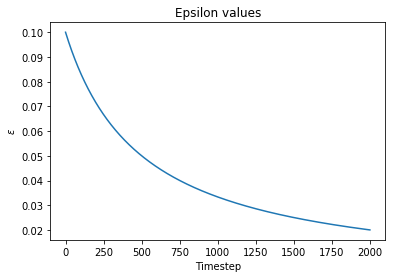

In [11]:
# epsilon 변화 그래프
steps = np.arange(EPISODE)
plt.title('Epsilon values')
plt.xlabel('Timestep')
plt.ylabel('$\\epsilon$')
plt.plot(steps, epsilon_list)

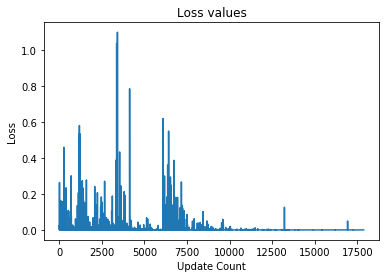

In [12]:
# loss 변화 그래프
update_count = np.arange(update_count)
plt.title('Loss values')
plt.xlabel('Update Count')
plt.ylabel('Loss')
plt.plot(update_count, loss_list)

### Test agent

In [13]:
state = env.reset()
state = np.reshape(state, [1])
done = False
limit = 0

epsilon = 0.0
while not done and limit < 30:
    curr_q = sess.run(q_value, feed_dict={inputs: state})
    action = np.argmax(curr_q)
    next_state, reward, done, _ = env.step(action)
    next_state = np.reshape(next_state, [1])
    env.render()
    state = next_state
    limit += 1

  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
